In [1]:
import sqlite3
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
def calculate_distance(lat1, lon1):
    # Radius of the Earth in kilometers
    earth_radius = 6371

    # Convert latitude and longitude to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(44.4914)
    lon2_rad = math.radians(20.2744)

    # Calculate the differences between the latitudes and longitudes
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = math.sin(d_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = earth_radius * c

    return distance

In [3]:
import sqlite3

values = ["SUT", "PSUT", "PR", "VPR"]

mapping = {
    "SUT": 0,
    "PSUT": 0.25,
    "PR": 0.5,
    "VPR": 0.75
}

# Connect to the database
conn = sqlite3.connect('db_prodaja-stanova_beograd.db')

# Create a cursor object
cursor = conn.cursor()
df = pd.read_sql_query("SELECT * FROM mytable", conn)

# Execute a SELECT query
cursor.execute("SELECT * FROM mytable")

X_data = list()
Y_data = list()
full_data = list()

# Fetch and print rows one by one
row1 = cursor.fetchone()
row = cursor.fetchone()
while row is not None:
    # print(row)
    coordinates = row[4]
    latitude, longitude = coordinates.split(',')
    distance = calculate_distance(float(latitude), float(longitude))
    

    broj_soba = row[5]

    if broj_soba == None:
        row = cursor.fetchone()
        continue
    broj_soba = float(broj_soba) if broj_soba != '5+' else 5.0


    kvadratura = float(row[6])
    if kvadratura == None:
        row = cursor.fetchone()
        continue


    sprat = row[7]
    if sprat == None:
        row = cursor.fetchone()
        # print(sprat)
        continue
    if sprat in values:
        sprat = mapping[sprat]
    else:
        sprat = float(sprat)
    sprat = math.log2(sprat + 1)


    # print(row)

    tip_gradnje = row[8]
    tip_gradnje = 1 if tip_gradnje == 'Novogradnja' else 0
    # else:
    #     break
    uknjizen = float(row[9])
    lift = float(row[10])
    garaza = float(row[11])
    terasa = float(row[12])
    pdv = float(row[13])

    cena = float(row[16])
    # , legal, air_c, elevator, garage

    row_x_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv]
    row_full_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv, cena]
    full_data.append(row_full_data)
    X_data.append(row_x_data)
    Y_data.append(cena)

    row = cursor.fetchone()

# Close the connection
conn.close()

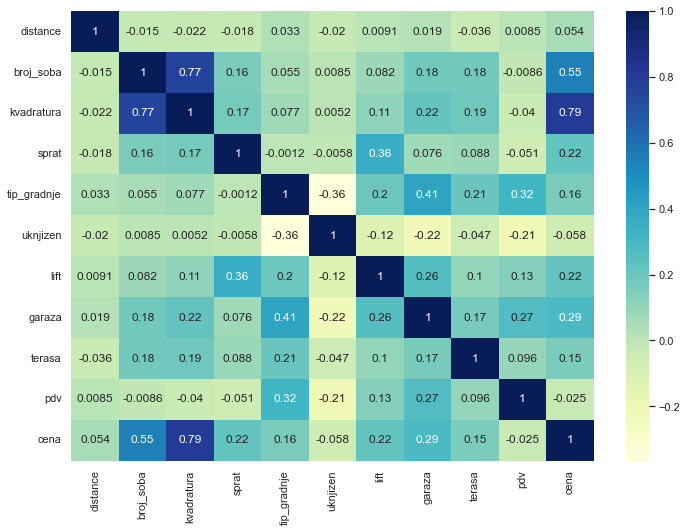

In [4]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv', 'cena']
df = pd.DataFrame(full_data, columns=header)
price_ranges = [0, 50000, 100000, 150000, 200000, 500000, float('inf')]
categories = [0,1,2,3,4,5]
# corrM = df.corr()
# corrM
sns.set(rc={'figure.figsize':(11.7,8.27)})
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [5]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
df_x = pd.DataFrame(X_data, columns=header)
y_data = df['cena']
MinMaxScaler = preprocessing.MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(X_data)
X_train, X_test, y_train, y_test = train_test_split(X_data_minmax, y_data,test_size=0.2, random_state = 1)

In [6]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [7]:
ypred = classifier.predict(X_test)
result = confusion_matrix(y_test, ypred)
sns.heatmap(result, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show() 
result1 = classification_report(y_test, ypred, output_dict=True)
report_df = pd.DataFrame(result1)

# Create a heatmap using Seaborn
sns.heatmap(report_df.iloc[:-1, :].astype(float).transpose(), annot=True, cmap='Blues', cbar=False)

# Set labels and title
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report')
result2 = accuracy_score(y_test,ypred)
print("ACCURACY: ",result2)